In [1]:
%reset
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np
import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import model_MultiShapeCirclesTranslation as model

torch.set_default_tensor_type(torch.DoubleTensor)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
nb_pts1 = 10
nb_pts2 = 7
dim = 2

o1 = torch.tensor([0.,0.])
o2 = torch.tensor([10.,0.])
origin = [o1,o2]
r1 = 1.
r2 = 2.
radius = [r1, r2]
nb_pts = [nb_pts1, nb_pts2]
source = mm.multipleCircles(origin, radius, nb_pts)

origin_target = [[0,5], [10,-5]]
target = mm.multipleCircles(origin, [2., 1.], nb_pts)

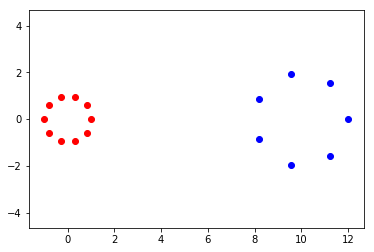

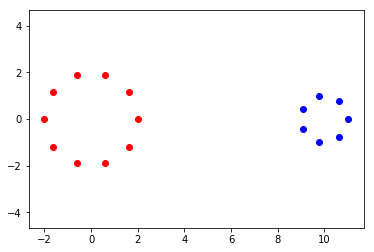

In [3]:
plt.figure()
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

plt.figure()
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [4]:
# Defining the deformation modules
sigma1 = 2
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
#trans1 = dm.deformationmodules.Translations(manifold1, sigma1)
#man_local1 = dm.manifold.Landmarks(2,1)
#scal1 = dm.deformationmodules.LocalScaling(man_local1, sigma1)

sigma2 = 2
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
#trans2 = dm.deformationmodules.Translations(manifold2, sigma2)
#man_local2 = dm.manifold.Landmarks(2,1)
#scal2 = dm.deformationmodules.LocalScaling(man_local2, sigma2)

#module_list = [scal1, scal2]
#sigma_bg = 0.1
#modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [5]:
scal1 = dm.deformationmodules.GlobalScaling(manifold1, sigma1)
scal2 = dm.deformationmodules.GlobalScaling(manifold2, sigma2)
module_list = [scal1, scal2]
sigma_bg = 0.1
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [6]:
constr_Id = dm.constraints.Identity()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [7]:
#gd0_list = [mm.computeCenter(source[0]), mm.computeCenter(source[1]), [mm.computeCenter(source[0]), mm.computeCenter(source[1])]]
#mom0_list = [torch.zeros(dim), torch.zeros(dim), [torch.zeros(dim), torch.zeros(dim)]]

In [8]:
gd0_list = [*source, source]
mom0_list = [*[torch.zeros(gd.shape) for gd in modules.manifold.gd[:-1]], [torch.zeros(gd.shape) for gd in modules.manifold.gd[-1]]]

In [9]:
H.module.manifold.fill_gd([gd0_list[0].view(-1), gd0_list[1].view(-1), [gd0_list[2][0].view(-1), gd0_list[2][1].view(-1)]])
H.module.manifold.fill_cotan([mom0_list[0].view(-1), mom0_list[1].view(-1), [mom0_list[2][0].view(-1), mom0_list[2][1].view(-1)]])
H.geodesic_controls()

In [10]:
# set parameters
reg_param = 10**-2 # regularisation parameter

gd0_tensor = torch.cat([gd0_list[0], gd0_list[1], gd0_list[2][0], gd0_list[2][1]],0).requires_grad_().view(-1)
mom0_tensor = torch.cat([mom0_list[0], mom0_list[1], mom0_list[2][0], mom0_list[2][1]],0).requires_grad_().view(-1)
    
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id, target, dim, reg_param)

# do registration
X = [gd0_tensor, mom0_tensor]
X = model.gradientdescent(EnergyFunctional, X)

cost: 0.0223205086356 attach: 11.708323868869737
 iter : 0  ,total energy: 11.730644377505298
cost: 0.0223205086356 attach: 11.708323868869737
cost: 0.0223150702722 attach: 11.70514911654661
c 0
 iter : 0  ,total energy: 11.727464186818844
cost: 0.0223150702722 attach: 11.70514911654661
cost: 0.0223091097585 attach: 11.701339946758942
c 0
 iter : 1  ,total energy: 11.723649056517448
cost: 0.0223091097585 attach: 11.701339946758942
cost: 0.0223027711252 attach: 11.696769710481718
c 0
 iter : 2  ,total energy: 11.719072481606872
cost: 0.0223027711252 attach: 11.696769710481718
cost: 0.0222963362635 attach: 11.691286532013049
c 0
 iter : 3  ,total energy: 11.71358286827657
cost: 0.0222963362635 attach: 11.691286532013049
cost: 0.0222903002864 attach: 11.684708308988009
c 0
 iter : 4  ,total energy: 11.706998609274399
cost: 0.0222903002864 attach: 11.684708308988009
cost: 0.0222854828463 attach: 11.676816732329257
c 0
 iter : 5  ,total energy: 11.699102215175522
cost: 0.0222854828463 attac

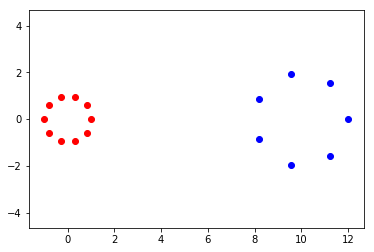

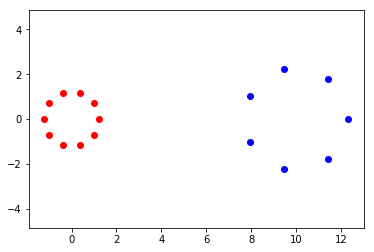

In [11]:
plt.figure()
plt.scatter(gd0_list[0].view(-1,2)[:, 0].detach().numpy(), gd0_list[0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(gd0_list[1].view(-1,2)[:, 0].detach().numpy(), gd0_list[1].view(-1,2)[:, 1].detach().numpy(), c='blue')
plt.axis('equal')

gd_moved = EnergyFunctional.h.module.manifold.gd

plt.figure()
plt.scatter(gd_moved[0].view(-1,2)[:, 0].detach().numpy(), gd_moved[0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(gd_moved[1].view(-1,2)[:, 0].detach().numpy(), gd_moved[1].view(-1,2)[:, 1].detach().numpy(), c='blue')
plt.axis('equal')

plt.show()

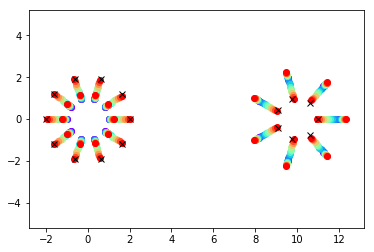

In [12]:
H.module.manifold.fill_gd(EnergyFunctional.tensor2list(X[0]))
H.module.manifold.fill_cotan(EnergyFunctional.tensor2list(X[1]))

states, controls = dm.shooting.shoot_euler(H, it=10)


import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

plt.figure()
for s,c in zip(states, colors):
    plt.scatter(s.gd[0].view(-1,2)[:, 0].detach().numpy(), s.gd[0].view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s.gd[1].view(-1,2)[:, 0].detach().numpy(), s.gd[1].view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s.gd[2][0].view(-1,2)[:, 0].detach().numpy(), s.gd[2][0].view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s.gd[2][1].view(-1,2)[:, 0].detach().numpy(), s.gd[2][1].view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

    
plt.axis('equal')
plt.show()

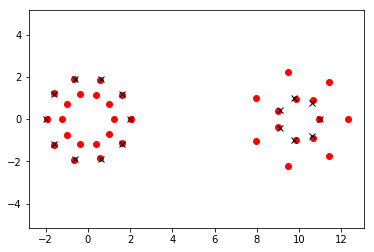

In [13]:
plt.figure()
s = states[-1]
plt.scatter(s.gd[0].view(-1,2)[:, 0].detach().numpy(), s.gd[0].view(-1,2)[:, 1].detach().numpy(), c=c)
plt.scatter(s.gd[1].view(-1,2)[:, 0].detach().numpy(), s.gd[1].view(-1,2)[:, 1].detach().numpy(), c=c)
plt.scatter(s.gd[2][0].view(-1,2)[:, 0].detach().numpy(), s.gd[2][0].view(-1,2)[:, 1].detach().numpy(), c=c)
plt.scatter(s.gd[2][1].view(-1,2)[:, 0].detach().numpy(), s.gd[2][1].view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')
plt.axis('equal')
plt.show()

In [20]:
from defmod.attachement import L2NormAttachement

print(torch.sqrt(sum((s.gd[0].view(-1)-target[0].view(-1))**2)))

tensor(2.4539, grad_fn=<SqrtBackward>)


In [21]:
controls

[[tensor([4.7423], grad_fn=<ViewBackward>),
  tensor([-15.3773], grad_fn=<ViewBackward>),
  [tensor([ 8.8154e-01,  1.9126e-15,  7.0127e-01,  4.8151e-01,  2.4579e-01,
            8.0174e-01, -2.8431e-01,  8.2975e-01, -6.8656e-01,  5.2680e-01,
           -8.3390e-01,  1.2750e-15, -6.8656e-01, -5.2680e-01, -2.8431e-01,
           -8.2975e-01,  2.4579e-01, -8.0174e-01,  7.0127e-01, -4.8151e-01],
          grad_fn=<SliceBackward>),
   tensor([-3.8553e+00, -3.1924e-15, -2.2321e+00, -2.6582e+00,  9.9509e-01,
           -3.6490e+00,  3.1646e+00, -1.7429e+00,  3.1646e+00,  1.7429e+00,
            9.9509e-01,  3.6490e+00, -2.2321e+00,  2.6582e+00],
          grad_fn=<SliceBackward>)]],
 [tensor([4.5924], grad_fn=<ViewBackward>),
  tensor([-16.3648], grad_fn=<ViewBackward>),
  [tensor([ 8.9977e-01,  1.9250e-15,  7.1546e-01,  4.9042e-01,  2.5011e-01,
            8.1731e-01, -2.9055e-01,  8.4665e-01, -6.9999e-01,  5.3796e-01,
           -8.4982e-01,  1.2833e-15, -6.9999e-01, -5.3796e-01, -2.9055e-0

In [47]:
# 2 Modules
def controlslist2tensor(controls_list):
    return torch.cat([controls_list[0].view(-1),controls_list[1].view(-1), controls_list[-1][0].view(-1),controls_list[-1][1].view(-1)])

def controlstensor2list(controls, nb_pts, dim):
    n = sum(nb_pts)
    return [controls[:dim*nb_pts[0]], controls[dim*nb_pts[0]:dim*(nb_pts[0]+nb_pts[1])], [controls[dim*n:dim*(n+nb_pts[0])], controls[dim*(n+nb_pts[0]):]]]

def gdtensor2list(gdtensor, nb_pts, dim):
    gdlist = []
    gdlist_bg = []
    j = 0
    n = sum(nb_pts)
    for i in range(len(nb_pts)):
        gdlist.append(gdtensor[dim*j:dim*(j+nb_pts[i])])
        gdlist_bg.append(gdtensor[dim*(n+j):dim*(n+j+nb_pts[i])])
        j = j + nb_pts[i]
    return [*gdlist, gdlist_bg]

def gdlist2tensor(gdlist):
    return torch.cat([*gdlist[:-1],*gdlist[-1]],0)

nb_pts = [nb_pts1, nb_pts2]

In [48]:
def test_gradcheck_Hamiltonian_2modules():
    def hamiltonian(gd, mom, controls, l):
        
        H.module.fill_l(l)
        H.module.manifold.fill_gd(gdtensor2list(gd, [nb_pts1, nb_pts2], dim))
        H.module.manifold.fill_cotan(controlstensor2list(mom, [nb_pts1, nb_pts2], dim))
        H.module.fill_controls(controlstensor2list(controls, [nb_pts1, nb_pts2], dim))
        H.geodesic_controls()
        
        return H()
    return torch.autograd.gradcheck(hamiltonian, (gd, mom, controls, modules.l), raise_exception=True)

modules.compute_geodesic_variables(constr_Id)

gd = gdlist2tensor(modules.manifold.gd)
mom = controlslist2tensor(modules.manifold.cotan)
controls = controlslist2tensor(modules.controls)
l = modules.l

test_gradcheck_Hamiltonian_2modules()

True